In [1]:
from src.dl.inference.inferer import Inferer
import src.dl.lightning as lightning
from src.config import CONFIG

In [3]:
lightning_model = lightning.SegModel.from_experiment(name="shortskip_consep", version="residual_preact_hover")

inferer = Inferer(
    lightning_model,
    dataset="consep",
    patch_size=(256, 256),
    stride_size=80,
    fn_pattern="*",
    data_fold="test",
    model_weights="last",
    apply_weights=True,
    post_proc_method="hover"
)

In [5]:
# lightning_model

In [6]:
inferer.run_inference()

Inference: /home/local/leos/Dippa/datasets/data/consep/test/images: 100%|██████████| 2/2 [01:06<00:00, 33.42s/batch, patches=4046/4046]


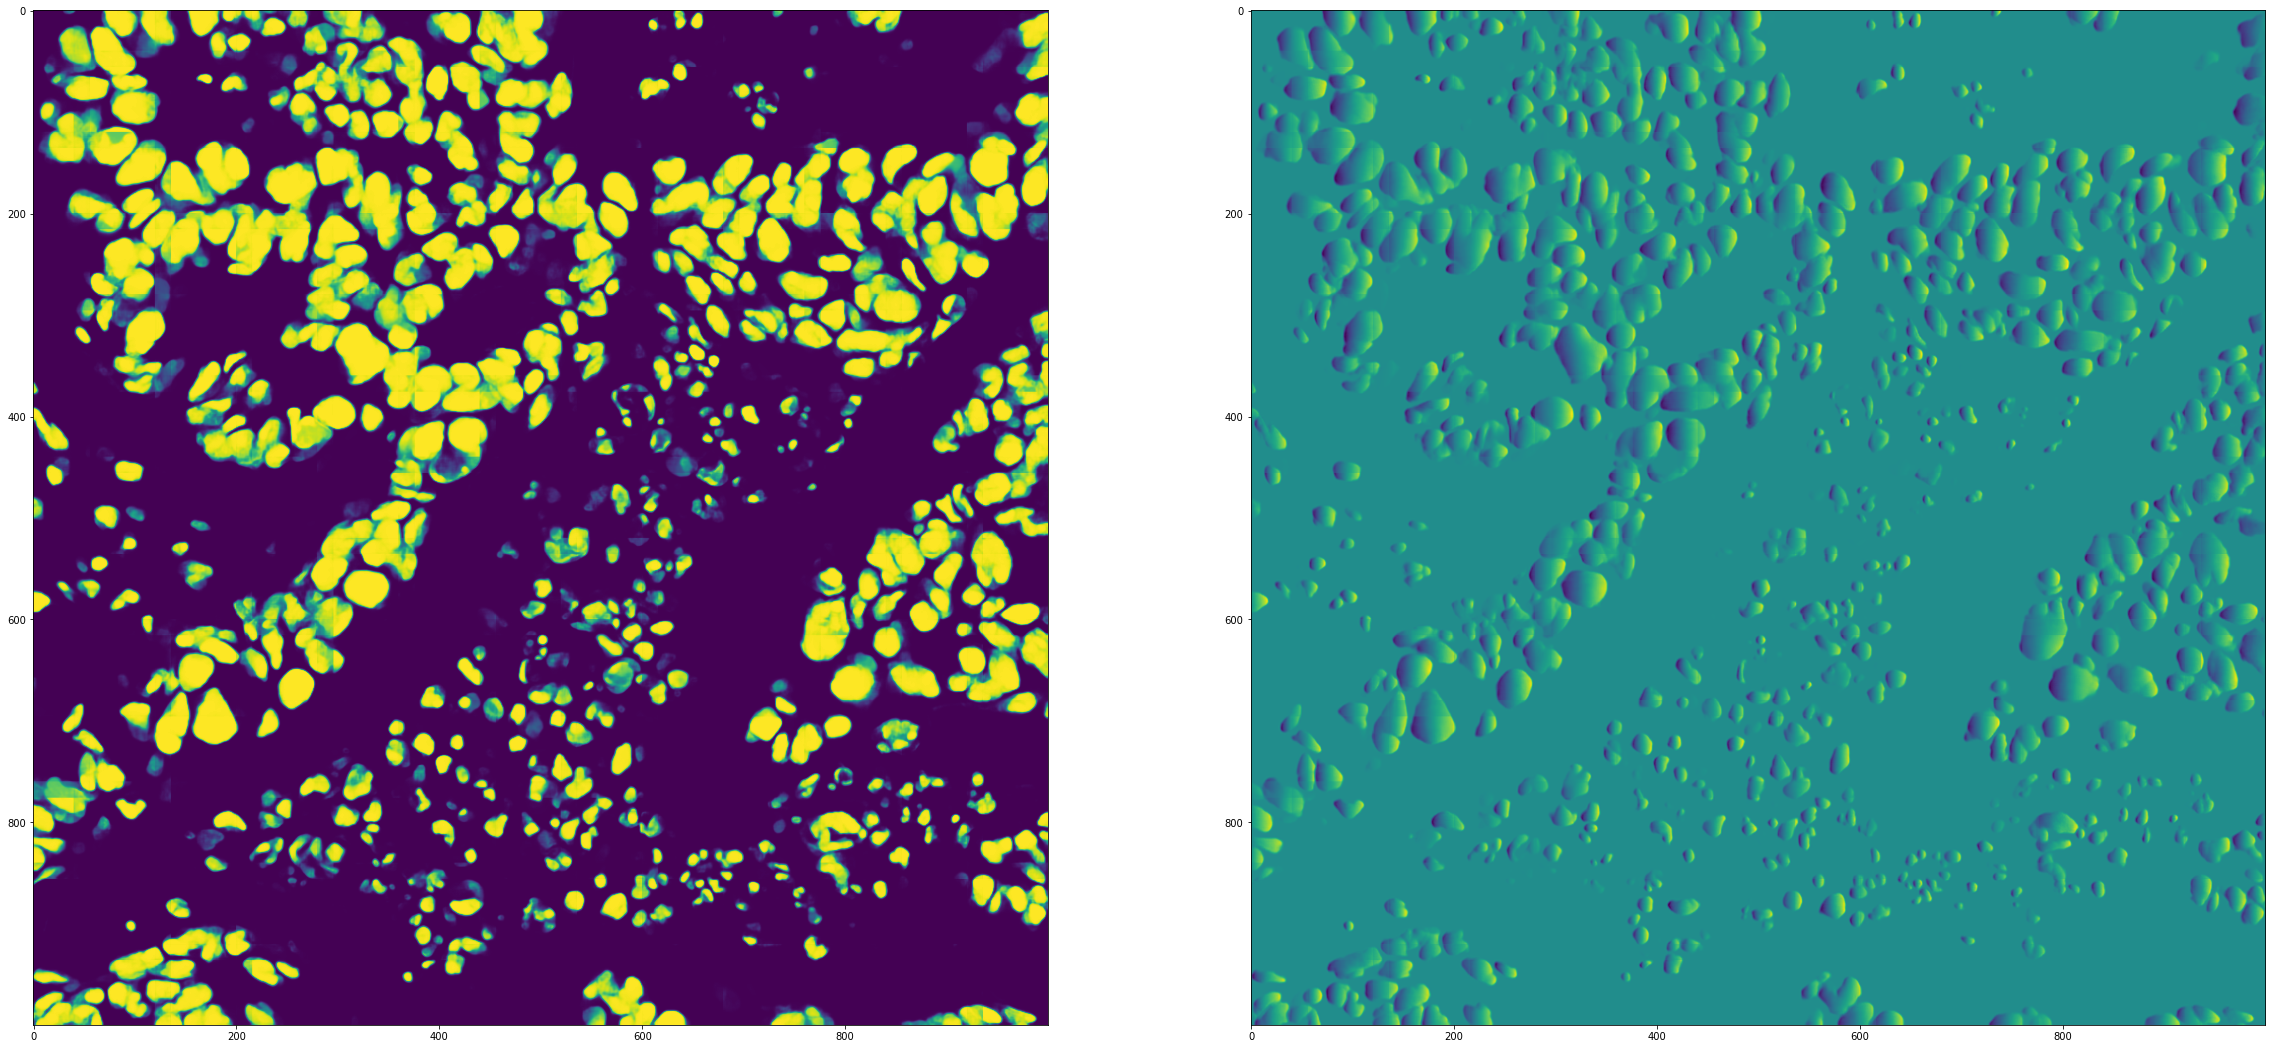

In [7]:
import matplotlib.pyplot as plt 
from skimage.color import label2rgb

key = "test_11"
fig, ax = plt.subplots(1, 2, figsize=(40, 40))
ax[0].imshow(inferer.soft_insts[key][..., 1])
ax[1].imshow(inferer.aux_maps[key][..., 0])

In [8]:
inferer.post_process()

100%|██████████| 14/14 [00:39<00:00,  2.85s/it]


In [9]:
pattern_list = None
binary_scores = inferer.benchmark_insts(pattern_list=pattern_list, file_prefix="hover_residual_preact")
binary_scores

100%|██████████| 14/14 [01:23<00:00,  5.98s/it]


,AJI,AJI_plus,DICE2,PQ,SQ,DQ,inst_recall,inst_precision,splits,merges
name,,,,,,,,,,
test_1,0.512743,0.556343,0.459071,0.520689,0.750957,0.693367,0.640462,0.755798,0.492316,0.704497
test_10,0.598013,0.613370,0.489585,0.595987,0.786702,0.757576,0.769231,0.746269,0.818255,0.434865
test_11,0.439110,0.517195,0.442920,0.360053,0.741109,0.485830,0.389972,0.644172,0.671613,0.823934
test_12,0.621044,0.649614,0.617224,0.602119,0.784067,0.767943,0.750000,0.786765,0.405896,0.352982
test_13,0.559959,0.610119,0.637605,0.547771,0.788418,0.694772,0.606328,0.813425,0.558741,0.886813
test_14,0.648174,0.653049,0.608779,0.630788,0.808159,0.780526,0.908273,0.684282,1.049968,0.314110
test_2,0.541185,0.550612,0.711098,0.512782,0.754568,0.679570,0.644898,0.718182,0.320731,0.460779
test_3,0.579524,0.614073,0.496996,0.532708,0.764914,0.696429,0.692893,0.700000,0.431366,0.627570
test_4,0.601436,0.627289,0.487313,0.534310,0.775014,0.689420,0.724880,0.657267,0.621046,0.589873


In [10]:
pattern_list = None
type_scores = inferer.benchmark_types(pattern_list=pattern_list, file_prefix="hover_residual_preact")
type_scores = type_scores[type_scores.index.str.contains("avg")]
type_scores

100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


,AJI,AJI_plus,DICE2,PQ,SQ,DQ,inst_recall,inst_precision,splits,merges
name,,,,,,,,,,
miscellanous_avg_for_the_set,0.091726,0.094289,0.368578,0.089707,0.429534,0.118219,0.077962,0.340344,0.011676,0.078048
inflammatory_avg_for_the_set,0.418000,0.421327,0.827366,0.473231,0.832852,0.568521,0.596082,0.658277,0.084980,0.089678
epithelial_avg_for_the_set,0.524052,0.557749,0.447956,0.480042,0.760472,0.628196,0.645714,0.624356,0.524369,0.424744
spindle_avg_for_the_set,0.375166,0.383633,0.633309,0.377032,0.748907,0.503318,0.514044,0.531118,0.239344,0.315149
